# Logistic Regression - Predicting shipwreck survival

In this week's assignment you will implement a classification algorithm named Logistic Regression. This sounds very counter-intuitive, as regression is something entirely different from classification, but the Logistic Regression model is actually estimating the probability (which is a continuous value) that data can be assigned to a specific class out of a set of classes. We will focus on so-called binary classification problems, wherein there are two possible classes. Some of the examples of binary classification problems that Logistic Regression is able to solve are: 

- Email; spam or not spam 
- Online transactions; fraud or not fraud
- Tumor; malignant or benign 

In this notebook, we will be using the classic Titanic dataset. This data consists of demographic and traveling information for 891 of the Titanic's passengers, and the goal is to predict which of these passengers survived. 

Here is a summary of the data set's attributes:

- *PassengerId*: passenger ID assigned in this dataset
- *Survived*: a Boolean indicating whether the passenger survived or not (0 = No; 1 = Yes); this is our target
- *Pclass*: passenger class (1 = 1st; 2 = 2nd; 3 = 3rd)
- *Name*: field containing the name and title of the passenger
- *Sex*: male/female
- *Age*: age of the passenger in years
- *SibSp*: number of siblings/spouses aboard
- *Parch*: number of parents/children aboard
- *Ticket*: ticket number
- *Fare*: passenger fare in British Pounds
- *Cabin*: location of the cabin, consisting of a letter indicating the deck, and a cabin number.
- *Embarked*: port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

As you can probably see, the dataset contains a mix of textual, continuous, categorical, and boolean variables. Before we can get into implementing and applying Logistic Regression, we will have to clean up the data. We will lead you through this process using functions a data-scientist might use, providing you with the tools that will help you prepare your own data in the future.

Run the code below to load the data and display the first few rows of that data set.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('titanic.csv')

display(data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### A quick view

From the first five rows displayed in the table above, you might be able to see that there are multiple types of variables: we have integers, strings, floats, and a few *NaN*'s, which are missing values. Let's take a quick look to see what the types of data that we are dealing with actually are. A tool a data-scientist might use here is Panda's [`df.info()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html), which is a method that can be applied to any `DataFrame` that shows information about that frame, including the index, datatype for each column, non-null values, and memory usage.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


As you can see we have 891 entries, numbered 0 to 890, with 12 different features. Of these 12 features, *Survived* will be our target features. Out of 12 columns, 2 are floats, 5 are integers, and 5 are "objects" which is the generic type, but in this case these are strings. Out of all of the columns, there are 3 that have some missing values. We will need to fix these missing values later.

Let's take a better look at what the numeric columns, i.e. those that contain integers and floats, look like. For this, we will use Panda's [`df.describe`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html?highlight=describe#pandas.DataFrame.describe), which is a method that can be applied to any `DataFrame` to show its descriptive statistics, which summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [3]:
display(data.describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The result is a table showing some statistics for each of the columns. The `count` is the number of values that are not NaN in that specific column. We can also see the mean, standard deviation, minimum, maximum, and percentiles for each of the columns. Percentiles are covered in *SOWISO* chapter 2 (Describing Data), the $50^{th}$ percentile corresponds to the median value. Let's see what we can conclude from this table and the previous one:

- *PassengerId* is a column that runs from 1 to 891, indicating the index of a passenger in this dataset. This variable has no descriptive value for the passenger, but it could still cause our machine learning model to find some correlations that are really just noise, so we should delete this whole column before using the data for training.
- The mean of *Survived* indicates that out of the 891 people in our dataset, only ~38% of people survived. This can be deduced from the mean of the column, because the value 1 corresponds to survived and 0 corresponds to did not survive. As an example, when 90% of these values would be 1, we would end up with a mean of 0.9, as the other values are all zeros.
- There are more people in *Passenger Class* 3 than in class 1 and 2 combined. This can be concluded from the fact that from the 50th percentile to the maximum value, every passenger is in third class.
- There is at least one baby in our dataset, with an *Age* of 0.42, or 5 months. The oldest person is 80 years old. We can see this from the min and max values of the *Age* column.
- There are 277 people of which we do not know the *Age*. We have 891 data entries, but the `count` for age is 714, so 891 - 714 = 277.
- The majority of people has no *Siblings/Spouses* aboard. This can be concluded from the percentiles.
- The majority of people has no *Parents/Children* aboard. This can be concluded from the percentiles.
- There is a big difference in scale in data. Fare can be up to 512 pounds while the number of *Parents/Children* on board is only up to 6.  We can also see this in the standard deviations, where the difference is also very large. In his videos, Andrew Ng talks about feature scaling, which is something we should apply here. We will discuss this later.

Often, these tables can tell you a lot about the data you are working with, and might provide you with intuitions on what would work best for this dataset. We will spend some more time on analysing the data at the end of this notebook.

### Assignment 1: Cleaning the data

First let's remove feature from the data that we won't use in the Logistic Regression model. Uniquely identifying features are generally a bad idea to include in training data, as they will never generalize well to new samples. In theory, the model might learn that a passenger with a specific ID is less likely to survive, but that is only relevant to the specific training data used and unlikely to improve predictions for other samples. In order to create a model that will generalize better, we'll completely remove *PassengerId*, *Name* and *Ticket* from this data set.

Create a new DataFrame called `clean_data` that is a direct copy of our original `data`, but does not include the columns *PassengerId*, *Name* and *Ticket*. Take a look at Panda's [`df.drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) function, which can be used to delete columns from a given `DataFrame`, when setting the `axis` parameter correctly. The method returns a new `Dataframe` without the rows/columns that were deleted.

In [4]:
# YOUR CODE HERE
# drop columns
clean_data = data.drop(columns=['PassengerId', 'Name', 'Ticket'])

clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


If you did the step above correctly, the `clean_data` DataFrame should now only have 9 columns, as 3 were removed. Looking at this description, we can see there are quite a few missing values in the data set, which are indicated as *null* values. For example, the *Cabin* feature has $204$ non-null values, while the data set consists of $891$ entries, meaning there are $687$ values missing here.

One could say that the absence of information is also information, but when training a machine learning model, most models cannot make any predictions when one of the input variables is missing, making these samples unusable. When you encounter missing values, you have multiple options for dealing with them:

* You can delete each row (sample) that contains a missing value
* You can delete the whole column (feature) containing the missing values
* You can replace the missing values with some other value

Which of these you choose depends on the specific feature, the size of your data set and number of values missing. For the *Cabin* feature, the majority of the values are actually missing, which makes dropping the feature entirely a good solution. Note that we are still throwing away some potentially useful information here, as a cabin number might converted to information on where the passenger was on the ship, which in turn might give information on if a passenger would have been able to reach a lifeboat on time. In a more advanced data processing pipeline we might still include some of this data, but that would include data mining techniques that are beyond the scope of this notebook.

So, for now, we'll just remove the *Cabin* column completely, as for most of the samples it does not contain any information anyway. Again, use [`df.drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html), this time to remove the *Cabin* column from the `clean_data`. Remember to store the result into `clean_data` again, as the function returns the new DataFrame.


In [5]:
# YOUR CODE HERE
# drop cabin column
clean_data = clean_data.drop(columns=['Cabin'])

clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Next, let's take a look the *Embarked* missing values. There appear to only be $2$ values missing here, as there are $889$ non-null values. The most common solution in such a case is to just remove those two samples from data set completely, as you'll only remove a few samples from your data, while retaining the *Embarked* information for most of them.

For this you can use the function [`df.dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html), which removes missing values from a DataFrame. As we only want to apply this solution to the *Embarked* column, make sure to use the optional argument `subset` here, which you can give a list of column names to include in the operation.

In [6]:
# YOUR CODE HERE
# drop Embarked column
clean_data = clean_data.dropna(axis = 0, how = 'any', thresh = None, subset = ['Embarked'], inplace = False)

clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


The only remaining missing values should now be the $177$ passengers for which we do not know the age. Here, deleting the rows really isn't a great option, as we don't have a lot of data to start with, and we need as many training samples as possible to create an accurate model. Deleting the column also wouldn't be a good option, as there are many cases where we *do* have the age, and the age of a person will probably be a good indicator for whether a person survived or not. The third option, replacing the missing values, remains, but we have to find a method that will not skew our results. 

There are multiple ways of replacing missing values, but it is important to find a method that does not affect the outcome of our model too much. Replacing the values randomly will probably create a lot of noise and outliers, and therefore might prevent the model from learning any real correlations between age and survival of the passenger.  So, we will use a method that replaces missing values with values that are as generic as possible, as to not skew the data too much, by replacing all missing values with a value that is inferred from the data that is available. The easiest option for this is to just use the *mean* of all the non-missing values as the replacement value.

In the cell below, use Panda's [`df.fillna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) function to replace every missing value in the *Age* column of `clean_data` with the average age based on all the non-missing values. You can use the [`mean()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) function on the *Age* column to compute the average age. Select the column *Age*, apply `fillna` to replace every missing value with the computed mean value and then store the result in the *Age* column to overwrite it.

In [7]:
# YOUR CODE HERE
#Select the column Age and compute mean value
df_age = clean_data['Age'] 
mean_age = df_age.mean()


#select Age column and overwrite NA values with mean values.
clean_data['Age'] = clean_data['Age'].fillna(value = mean_age, method = None, inplace = False, limit = None, downcast = None)

clean_data.info()
display(clean_data.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.642093,0.524184,0.382452,32.096681
std,0.486260,0.834700,12.968346,1.103705,0.806761,49.697504
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,29.642093,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
assert len(clean_data) == 889, "Something went wrong while cleaning the data. Did you remove the rows with no data for \'embarked\'?" 
assert not clean_data.isnull().any().any(), "Something went wrong while cleaning the data. There are still missing values in your dataframe."
print("Solution seems correct!")

Solution seems correct!


As you can see, all missing values in the column *Age* have now been replaced with the average. This means that the average of the column has not changed. However, this solution is still not ideal. We have changed the standard deviation and the percentiles, which indicates that we have changed the entire distribution of the data. As there is no way to recover the real data, for now we will settle for this solution.

Finally, we will have to transform the columns *Sex* and *Embarked* from categorical data into a numerical type that the Logistic Regression can work with. The column *Sex* has two categories, male or female, while the port where passengers *Embarked* has three categories; C = Cherbourg, Q = Queenstown, or S = Southampton. In the previous module, you learned about one-hot encoding, which is exactly what we will use here too. Pandas has a method named [`get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) that transforms data from categorical to a one-hot encoded set of columns.

Note that, for now, we will choose to interpret the *Passenger Class* as a numeric variable, as we won't one-hot encode it. However, you could make the argument that it is actually a categorical variable, as it only really has three values. In this case, both interpretations of the variable are valid, as it is a categorical variable with ordinal properties; second class is actually something "between" first and third class. Using the variable as if it is numerical, however, *does* imply that the difference between first and second class is the same as the difference between second and third class. Using the variable as if it is categorical implies that there is no order, and that the three different classes have no connection other than that you can only be part of one class.

In [9]:
# Create two new columns for the male and female one-hot encoding
sex = pd.get_dummies(clean_data['Sex'])

# Create three new columns for port of embarkment one-hot encoding
embark = pd.get_dummies(clean_data['Embarked'])

# We no longer need these columns, as we will replace them soon
clean_data = clean_data.drop(['Sex','Embarked'], axis=1)

# Create the new dataframe with the one-hot columns we created from the categories in Sex and Embarked
clean_data = pd.concat([clean_data, sex, embark], axis=1)

clean_data.info()
display(clean_data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   female    889 non-null    uint8  
 7   male      889 non-null    uint8  
 8   C         889 non-null    uint8  
 9   Q         889 non-null    uint8  
 10  S         889 non-null    uint8  
dtypes: float64(2), int64(4), uint8(5)
memory usage: 53.0 KB


,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


### Final preparations

Now that all data is numerical, we can continue to the next step in processing the data. Earlier, we already observed that there is a big difference in the scale of each of the features in the data, which can impact the learning process for a model (see the theory video for more details). Feature scaling can be used to ensure that the different features in your dataset take on similar ranges of values.

Scipy's `stat` module has some interesting methods to do this, including the `zscore` method which you might also recognise from the theory video:

$$ \tilde{\mathbf{x}}_j = \frac{\mathbf{x}_j - \mu_j}{\sigma_j} $$

Here $\mathbf{x}_j$ is a vector of x-values for the $j^{th}$ column, $\mu_j$ and $\sigma_j$ are the (scalar) mean and standard deviation for that same column, and $\tilde{\mathbf{x}}_j$ is the scaled version of the feature vector. The basic principle here is that it transforms every value in the column $j$ to a value that indicates how many standard deviations the value originally was away from the mean of the data *in that column*. For example: a $Z$-score of $-2$ would indicate that the value was 2 standard deviations below the average, while a $Z$-score of $0$ would indicate that the value was actually equal to the mean of the column.

In the code below, we transform each of the original numerical data columns using the `zscore` method, by applying it to each of the elements in those columns. The function `zscore` conveniently takes care of computing all means and standard deviations for each column separately, and returns the scaled data.

Note that we do not want to apply this function to our newly one-hot encoded data, as those are already within a nice $[0,1]$ range and scaling these binary values by their mean and standard deviation wouldn't really make sense here.


In [10]:
from scipy.stats import zscore

numerical = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
clean_data[numerical] = clean_data[numerical].apply(zscore)

display(clean_data.describe())

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
count,889.000000,8.890000e+02,8.890000e+02,8.890000e+02,8.890000e+02,8.890000e+02,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,-1.793341e-16,-2.849239e-16,6.668831e-17,1.198891e-17,1.092115e-16,0.350956,0.649044,0.188976,0.086614,0.724409
std,0.486260,1.000563e+00,1.000563e+00,1.000563e+00,1.000563e+00,1.000563e+00,0.477538,0.477538,0.391710,0.281427,0.447063
min,0.000000,-1.572211e+00,-2.254608e+00,-4.751991e-01,-4.743259e-01,-6.462044e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-3.735013e-01,-5.896199e-01,-4.751991e-01,-4.743259e-01,-4.872378e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,8.252086e-01,-5.482138e-16,-4.751991e-01,-4.743259e-01,-3.551972e-01,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,8.252086e-01,4.133853e-01,4.313502e-01,-4.743259e-01,-2.207954e-02,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,8.252086e-01,3.885326e+00,6.777195e+00,6.967010e+00,9.668551e+00,1.000000,1.000000,1.000000,1.000000,1.000000


The columns that we have adjusted with our `zscore` function now all have a mean that is very close to zero, and a standard deviation that is very close to one. So, the resulting data is now sufficiently of equal scale, and mean-centered.

With the data completely cleaned up, the final step is to put the data into format useful for learning. This means splitting the data into the input features `X` and the target variable `y`. In addition, we'll convert the data to *Numpy* `ndarrays` here, so we can again easily use vectorization in our Logistic Regression implementation. We've used Pandas for reading the data and cleaning it up (which is where *Pandas* excels), and now we'll use *Numpy* for the actual learning / computation portion. Finally, we'll need to also split the data set into a training and test set for learning, for which we'll use the `sklearn` function `train_test_split`.

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into target "y" and input "X"
y_df = clean_data['Survived']
X_df = clean_data.drop('Survived', axis=1)

# Convert the Pandas DataFrames to Numpy ndarrays
X_np = X_df.to_numpy()
y_np = y_df.to_numpy()

#Split the data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, train_size=0.7, random_state=1265599650)

### Assignment 2: The Logistic function

For Logistic Regression, we require a function that generates probabilities; a function that gives outputs between 0 and 1 for **all** inputs. There are many functions that meet this description, but the one that is used in logistic regression is the logistic function:

$$ g(z) = \frac{1}{1+e^{-z}} $$

Implement the function `logistic_func` that can either take a single value `z`, or an array of values `z`, and compute the *Logistic* function for each.

*Hint:* Numpy built-in functions and basic arithmetic operations work on both Numpy arrays and single values. When the function detects that its input is a Numpy array, the operation it applies will be applied to each element in the array separately, the result being a Numpy array of the same shape as the input. This is called *element-wise application*, and many mathematical operations have Numpy versions that support element-wise application. Write your `logistic_func` in such a way that it can compute $g$ values for scalars or for entire vectors.

Then, write some code that can plot the results for the logistic function between $-5$ and $5$. Use Numpy's [`np.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html?highlight=linspace#numpy.linspace) to generate a range of $z$ values and use your `logistic_func` to calculate the corresponding $g$ values. Make sure the resulting plot looks correct, before moving on to the next step.

Text(0.5, 1.0, 'the results for the logistic function')

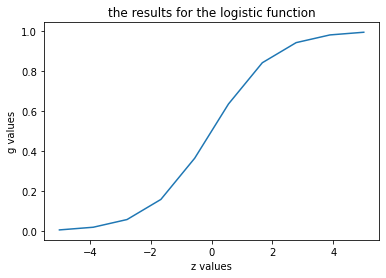

In [12]:
import math 

def logistic_func(z):
    # YOUR CODE HERE
    ''' 
    This function computes g values 
    '''
    
    # use np.exp to enable computation of single values and arrays of values for z
    g = 1 / (1 + np.exp(-z))
    
    
    return g
    
# YOUR CODE HERE
    
#Use Numpy's np.linspace to generate a range of  𝑧  values
z_values = np.linspace(-5.0, 5.0, num = 10)

# create empty list for g values and compute g value for every corresponging z value
g_values = []
for z in z_values:
    i = logistic_func(z)
    g_values.append(i)
    
# plot the results for the logistic function between  −5  and  5
plt.plot(z_values, g_values)
plt.xlabel("z values")
plt.ylabel("g values")
plt.title('the results for the logistic function')

### Assignment 3: Building the Logistic model

Next, we can start working on the hypothesis function, which will generate a vector of class probabilities, given some matrix of inputs $X$ and a vector of weights $\theta$. For logistic regression, we'll use the logistic function $g$ to transform the hypothesis we used in multivariate linear regression into a hypothesis function that only generates probabilities (i.e. results between 0 and 1):

$$ h_\theta(x^1) = g(\theta^Tx^1)$$
$$ h_\theta(x^2) = g(\theta^Tx^2)$$
$$ h_\theta(x^3) = g(\theta^Tx^3)$$
$$\dots$$
$$ h_\theta(x^n) = g(\theta^Tx^n)$$

This is exactly the same hypothesis equation as for multivariate linear regression, just with the logistic function $g$ applied as the final step. *Note:* The notation can be a little confusing here, as $x^i$ is a vector and the default shape for vectors is a *column* vector, even if $x^i$ in the complete data matrix $X$ is a *row* vector. This will actually get somewhat easier when we write out the full vectorized version using the matrix $X$, as the rows and columns get their "expected" shape. 

Here the function $g$ is the Logistic function defined above. As you've just written `logistic_func` specifically to also work on vectors, if we construct a vector of $z$ values for the whole model at once, then we could also write the entire hypothesis function in a vectorized form:

$$ \left[\begin{array}{cccc}
x_0^1 & x_1^1 & x_2^1 & \cdots & x_n^1 \\ 
x_0^2 & x_1^2 & x_2^2 & \cdots & x_n^2 \\ 
x_0^3 & x_1^3 & x_2^3 & \cdots & x_n^3 \\ 
\vdots & \vdots & \vdots & \ddots & \vdots \\
x_0^m & x_1^m & x_2^m & \cdots & x_n^m \\ 
\end{array} \right]
\left[\begin{array}{c} \theta_0 \\ \theta_1 \\
\theta_2 \\ \vdots \\ \theta_n \end{array} \right]
= \left[\begin{array}{cccc}
z^1\\
z^2\\
z^3\\
\dots \\
z^m \\
\end{array} \right]
$$

Next, we can apply the Logistic function to each of the elements of this $\mathbf{z}$ vector:

$$
\left[\begin{array}{cccc}
g(z^1)\\
g(z^2)\\
g(z^3)\\
\dots \\
g(z^m) \\
\end{array} \right]
=
\left[\begin{array}{c} h_{\theta}(x^1) \\ h_{\theta}(x^2) \\
h_{\theta}(x^3) \\ \vdots \\ h_{\theta}(x^m) \end{array} \right]
$$

Large parts of these equations should look familiar, as they're really just *Multivariate Linear Regression* with an extra *Logistic function* applied. This means you can (and should) take inspiration from your multivariate linear solutions, although some of the details will be a little different here.

First, write a function `add_x0`, which takes a matrix `X` and prepends a column vector of constant $1$ values to this matrix, returning this new matrix. Next, write the function `logistic_model` to compute the hypothesis vector of the model for some matrix `X` (which already has $x_0$ added, so no need to add it again) and parameter vector `theta`. Your solution for `logistic_model` should rely on `logistic_func` working for vectors as well as scalars, and so you shouldn't need any loops here at all.

In [13]:
def add_x0(x):
    # YOUR CODE HERE
    '''
    Thif function takes a matrix X and prepends a column vector of constant  1  values to this matrix, 
    returning this new matrix.
    '''
    x0 = np.ones((x.shape[0], 1)) 
    added = np.hstack((x0, x))
    
    return added

def logistic_model(X, theta):
    # YOUR CODE HERE
    '''
    This function computes the hypothesis vector of the model for 
    some matrix X (which already has  𝑥0  added in func add_x0)
    and parameter vector theta.
    '''
    
    z = np.matmul(X, theta)
    hypothesis_values = logistic_func(z)
    
    return hypothesis_values

# create matrix for X
X_train_x0 = add_x0(X_train)
X_test_x0 = add_x0(X_test)


### Assignment 4: The Cost function

Now that we can make predictions using an input matrix $X$, and our parameter weights $\theta$, we can evaluate the cost of our model. To be able to apply gradient descent, we will need a cost function that is convex when we use our logistic model to make predictions. This cost function for logistic regression is explained in detail in the theory videos, and is defined as:

$$J(\theta) = - \frac{1}{m} \sum_{i=1}^M y^i log(h_\theta(X^i)) + (1 - y^i) log(1 - h_\theta(X^i))$$

Implement the function `logistic_cost`. Use your `logistic_model` function to calculate the hypothesis vector $h_\theta(X)$. Just as with the cost function for *Multivariate Linear Regression*, it is actually possible to write this whole function using only linear algebra, and some element-wise function applications, although this one is a little harder.

*Hints:* Most mathematical functions have a *Numpy* version that supports element-wise application, which will really help here. If you're stuck on how to write all of this as matrix multiplications, you can also use the element-wise version of multiplication [np.multiply](https://numpy.org/doc/stable/reference/generated/numpy.multiply.html). Addition and subtraction are already element-wise by default, so all that then remains is summing the resulting vector.

In [1]:
def logistic_cost(theta, X, y):
    # YOUR CODE HERE
    '''
    This function takes as input matrix X and Y data and parameters theta.
    It uses the logistic_model function to calculate the hypothesis vector.
    It then uses this hypothesis factor to calculate the cost function.
    '''
    hypothesis_vector = logistic_model(X, theta)
    
    #set m to length of x
    m = X.shape[0]
    
    #cost = -1 / m * np.sum(y * np.log(X) + (1 - y) * (np.log(1 - X)))
    hypothesis_values = logistic_model(X, theta)
    
    part1 = np.multiply(y, np.log(hypothesis_values))
    part2 = np.multiply((1 - y), np.log(1 - hypothesis_values))
    summ = np.sum(part1 + part2)
    fraction = - (1 / m)
    cost = (fraction * summ)
    
    return cost


In [2]:
assert np.allclose(logistic_cost(np.ones(X_train_x0.shape[1]), X_train_x0, y_train), 2.013825365789087), 'Cost for training data seems incorrect'
print("Solution seems correct!")

NameError: name 'np' is not defined

### Assignment 5: Obtaining the Gradient terms for Logistic Regression

Manually taking the whole partial derivative of this cost function can be a little time consuming, but in order to still practice this skill, we'll just do a part of this derivative instead. For this part of the notebook, you should consult the `logistic_derivative.pdf` supplement, included as a part of the assignment. Read sections 1, 2 and 3 in the supplement, and then complete the steps of the partial derivative below, labeling each of the steps with their respective rules (as with the linear regression assignment).

$$\frac{\partial E_{\mathbf{\theta}}^i}{\partial h_{\mathbf{\theta}}^i} =
\frac{\partial}{\partial h_{\mathbf{\theta}}^i} \bigl(-y^i log(h_{\mathbf{\theta}}^i) -
(1 - y^i) log(1 - h_{\mathbf{\theta}}^i) \bigr)$$

**TODO:** *Your steps, each labeled with what rules you've applied, should go here*.

Partial derivatives on the left side:

Change the log into the natural log in order to get the derivatives. 
$$\frac{\partial E_{\mathbf{\theta}}^i}{\partial h_{\mathbf{\theta}}^i} =
\frac{\partial}{\partial h_{\mathbf{\theta}}^i} \bigl(-y^i In(h_{\mathbf{\theta}}^i) -
(1 - y^i) In(1 - h_{\mathbf{\theta}}^i) \bigr)$$


the product rule on both sides
$$\frac{\partial E_{\mathbf{\theta}}^i}{\partial h_{\mathbf{\theta}}^i} =
\frac{\partial}{\partial h_{\mathbf{\theta}}^i} \bigl(-y^i * 1 / (h_{\mathbf{\theta}}^i) 
+ 0 - (1 - y^i) * -1 * (1 - h_{\mathbf{\theta}}^i)) + 0 $$



constant factor rule on both sides
$$\frac{\partial E_{\mathbf{\theta}}^i}{\partial h_{\mathbf{\theta}}^i} =
\frac{-y^i}{h_{\mathbf{\theta}}^i} +
\frac{1 - y^i}{1 - h_{\mathbf{\theta}}^i}$$

Section 4 of the supplement is optional, but definitely read sections 5 and 6 before moving on to the next step. 

### Assignment 6: Gradient Vector and Gradient Descent

In the end, the partial derivatives for each of the $\theta$ parameters look exactly the same as for polynomial regression. While the applied hypothesis function $h$ changes, the rest of the derivative does not, even though the cost function is completely different. As a result, the equations for the $n+1$ partial derivatives for each of the $n+1$ parameters, in the notation of the theory videos, then just become:

$$\frac{\partial J}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^i) - y^i)x^i_0$$
$$\frac{\partial J}{\partial \theta_1} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^i) - y^i)x^i_1$$
$$\frac{\partial J}{\partial \theta_2} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^i) - y^i)x^i_2$$
$$\dots$$
$$\frac{\partial J}{\partial \theta_n} = \frac{1}{m} \sum_{i=1}^m (h_{\theta}(x^i) - y^i)x^i_n$$

Write the functions `gradient_vector` and `gradient_descent` for this *Logistic Regression* model. You should be able to reuse a lot of your code from *Multivariate Linear Regression* here, as a large part of this code actually hasn't changed!

In [16]:
def gradient_vector(theta, X, y):
    # YOUR CODE HERE
    # Compute the hypothesis values
    h = logistic_model(X, theta)
    
    #set m to length of x
    m = X.shape[0]
    
    # calculate derivative
    fraction = (1/m)
    error = h - y
    sum_error = np.matmul(X.T, error)
    partial_derivatives = fraction * sum_error
    
    return partial_derivatives

def gradient_descent(X, y, theta, alpha, thres=10**-6):
    # YOUR CODE HERE
    
    # pcik starting point
    previous_cost = math.inf

    # set starting value cost function vector
    new_cost = logistic_cost(theta, X, y)
    iterations = 0    
        
    # find gradient vector
    while previous_cost - new_cost > thres:
        previous_cost = new_cost

        # find gradient theta and move one step for the gradient vector
        gradient_theta = gradient_vector(theta, X, y)
        new_theta = theta - alpha * (gradient_theta)
        
        # compute the cost at this point new_theta
        new_cost = logistic_cost(new_theta, X, y)

        #check for diverging
        if previous_cost < new_cost:
            return theta
        
        # set theta to new theta
        theta = new_theta
        
    return theta

# Initialize theta to a zero vector of the correct shape
theta = np.zeros(X_train_x0.shape[1])


# Find the theta vector that minimizes the cost function
theta_hat = gradient_descent(X_train_x0, y_train, theta, 10**-4)


In [17]:
assert np.allclose(theta_hat, np.array([-0.17289611, -0.42245195, -0.16952217, -0.11465412, 0.08995297, 0.24693307, 0.47087209, -0.64376821, 0.05535226, 0.00347353, -0.2317219])), 'Optimal theta vector for training data seems incorrect'
print("Solution seems correct!")

Solution seems correct!


### Assignment 7: Inspecting the learning curves

While this model probably converges with the provided parameters, it is hard to tell if gradient descent actually converged to a *good* solution. In order to assess this, we'll make a modified version of gradient descent that plots the learning curves. Learning curves show how the cost changes with each step of gradient descent, and plotting them can tell you a lot about how well an algorithm converged.

You can plot the learning curve just for the training cost, where ideally you'd see the cost go down for each step (otherwise the algorithm is diverging) and eventually the cost would level off to almost flat, indicating that gradient descent cannot improve the parameters much further. You can also measure the testing or the validation cost at each step and see if this follows the same trend down as the training cost. If the training cost is going down, but your validation cost is going up, then your model must be overfitting.

Complete the function `gradient_descent_learning_curves`, which should implement exactly the same gradient descent algorithm as in the previous assignment. In addition, it should store the training and testing cost at every step of the algorithm, and store the number of iterations gradient descent took to converge. Once the algorithm is converged, the function should plot the training and the testing cost as a function of the number of iterations, clearly labeling which line in the figure belongs to which cost. Finally, the function should return the converged result of the `theta` parameter vector, as before.

The function will need a few additional arguments to determine the testing cost, namely `X_test` and `y_test`, so you should modify the function call accordingly. For this function call, you should also tweak the learning rate `alpha` and the convergence threshold `thres` and inspect the learning curves each time. Repeat this process and make sure you find a configuration you think has actually converged to a good solution.


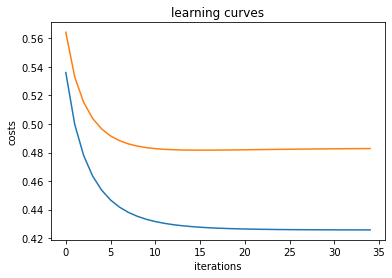

In [18]:
def gradient_descent_learning_curves(X_train, y_train, X_test, y_test, theta, alpha, thres):
    # YOUR CODE HERE
    
    # create lists for training and testing costs
    training_costs = []
    testing_costs = []
    
   # pcik starting point
    previous_cost = math.inf

    # set starting value cost function vector
    training_cost = logistic_cost(theta, X_train, y_train)
    counter_iterations = 0    
        
    # find gradient vector
    while previous_cost - training_cost > thres:
        counter_iterations += 1
        previous_cost = training_cost

        # find gradient theta and move one step for the gradient vector
        gradient_theta = gradient_vector(theta, X_train, y_train)
        new_theta = theta - alpha * (gradient_theta)
        
        # compute the cost at this point new_theta
        training_cost = logistic_cost(new_theta, X_train, y_train)
        training_costs.append(training_cost)
        
        # compute the cost at this point new_theta
        testing_cost = logistic_cost(new_theta, X_test, y_test)
        testing_costs.append(testing_cost)

        #check for diverging
        if previous_cost < training_cost:
            return theta
        
        # set theta to new theta
        theta = new_theta
        
    
    # plot costs
    plt.plot(range(counter_iterations), training_costs)
    plt.plot(range(counter_iterations), testing_costs)
    plt.xlabel("iterations")
    plt.ylabel("costs")
    plt.title('learning curves')
        
    return theta
    
    
# Initialize theta to a zero vector of the correct shape
theta_lc = np.zeros(X_train_x0.shape[1])
alpha_lc = 2
thres_lc = 10**-5

# Find the theta vector that minimizes the cost function
minimum_cost = gradient_descent_learning_curves(X_train_x0, y_train, X_test_x0, y_test, theta_lc, alpha_lc,  thres_lc)


**Q1. Explain which values you chose for the learning rate and convergence threshold of gradient descent. What happened to the learning curve when you changed these values?**

In one of his video's, Andrew Ng discussed that learning rates are ussually set somewhere near 0.001, 0.003, 0.01, 0.03, 0.1, 0.3. So I just tried 0.01 and 0.1. 0.01. But those did not seem like the best fits because the alpha could have been bigger. that makes sense because we ensured that all gradients are less than 1. With gradient values that are so low, we can increase alpha. So i picked alpha = 5 but that diverged / was inaccurate. alpha = 2 looks like a good because the line arrives at convergence the quickest, the slope goes down and slowly flattens out. 

The different thresholds that I picked all were between 10^-4 and 10^-10. The differences were not too big but the steepness of the descent of the lines increases. so I picked 10^-5 because with 10^-4, the line didn't really become flat. 10^-5 does show the convergence.
The most important thing seems to be to change alpha and then use the right threshold for a good combination of both.

**Q2. For this model, it is actually not possible to overfit, no matter how much you tweak the learning rate and convergence threshold. Explain why a Logistic Regression model with these inputs could never overfit the data.**

Because tweaking the learning rate and the convergence threshold does not change the (number of) parameters in this logistic regression model. Overfitting is more dependant on the parameters. Furthermore, this model one parameters for every variable, whichmakes it impossible to overfit.

### Assignment 8: Predictions

Now that we have a learned vector of weights $\theta$, we can use these weights to make predictions for our test samples `X_test`. The learned hypothesis function actually estimates the probability of the passengers in `X_test` to have survived the shipwreck or not.

$$P(y^i=1|x^i,\theta) = h_{\theta}(x^i)$$

Finally, these estimates of the probability that $y=1$ still need to be transformed into boolean predictions, which will be the actual classifications. In the end, this regression model should still predict that either the person has survived $y=1$, or that the person has not survived $y=0$.

Write the function `predict`, that takes a matrix of input values `X` and a vector of weights `theta`, and transforms them into a vector of boolean predictions. Use `logistic_model` to generate predictions, and then use a decision boundary of $h_\theta(x) \geq 0.5$ to determine when you should classify each sample as $y=1$.

In [19]:
def predict(X, theta):
    # YOUR CODE HERE
    '''
    This function takes as inpus a matrix of input values X and a vector of weights theta. 
    it uses the logistic model function to generate prediction (hypothesis value of y = 1, given input and weights).
    it transforms the hpothesis values to bool matrix (1 or 0, not true or false) using a decision boundary of 0.5.
    '''
    
    # calculate hypothesis values
    hypothesis_values = logistic_model(X, theta)   
    
    for i in range(len(hypothesis_values)):
        if hypothesis_values[i] >= 0.5:
            hypothesis_values[i] = 1
        else:
            hypothesis_values[i] = 0
            
    return hypothesis_values
    
    
predictions_train = predict(X_train_x0, theta_hat)
predictions_test = predict(X_test_x0, theta_hat)

### Assignment 9: Determining accuracy

Next, we would like to see how *accurate* our model is, now that we have trained it and it can generate predictions. Implement the function `calc_accuracy` that accepts a vector of `predictions` and a vector of *ground-truth* values `y`. The function should return the ratio of correct predictions (predictions where the value in `predictions` is equal to the value in `y`). The ideal situation where every classification is correct, should result in an accuracy of $1$.

In [20]:
def calc_accuracy(predictions, y):
    # YOUR CODE HERE
    '''
    This function takes as input two matrixes, prediction (with hypothesis values) and y (with ground-truth values)
    The for loop counts the number of predictions in which both matrices have the same output. 
    It returns the accuracy of the matrix predictions (predictions where the value in predictions is equal to the value in y).
    '''
    
    counter_correct = 0
    counter_total = 0
    
    for i in range(len(predictions)):
        counter_total += 1
        if predictions[i] == y[i]:
            counter_correct += 1
            
    accuracy = counter_correct / counter_total
    
    return accuracy


print(f"Training set accuracy: {calc_accuracy(predictions_train, y_train)}")
print(f"Testing set accuracy: {calc_accuracy(predictions_test, y_test)}")

Training set accuracy: 0.7942122186495176
Testing set accuracy: 0.7565543071161048


In [21]:
assert np.allclose(calc_accuracy(predict(X_test_x0, np.array([-0.17289611, -0.42245195, -0.16952217, -0.11465412, 0.08995297, 0.24693307, 0.47087209, -0.64376821, 0.05535226, 0.00347353, -0.2317219])), y_test), 0.7565543071161048), 'Accuracy for testing data seems incorrect'
print("Solution seems correct!")

Solution seems correct!


### Assignment 10: Confusion matrix

The accuracy we have just determined is, of course, one of the primary goals of building a model; we generally want a Machine Learning model to be as accurate as possible. However, it does not give much insight into in what way our model was accurate. As an example, let's say that we want to diagnose whether a patient has a virus. Of course we want our model to diagnose as accurately as possible, but there are two types of error the model could make:

1. A patient *has* the virus, but was diagnosed as being negative
2. A patient *does not have* the virus, but was diagnosed as being positive

One of these types of mistakes is potentially *much* more costly than the other, as falsely diagnosing a patient as negative could become very harmful for the patient and their environment. Although an extreme (and currently very relevant) example, it is quite often the case in classification that not every error has the same associated *cost*.

To give better insight into the performance of a classification algorithm, typically, a confusion matrix is made. The confusion matrix is a table layout that allows quick identification of the performance of a classification algorithm. Each *row* in the matrix represents the data that got predicted as a specific class, while each *column* represents the data that is actually in a class:

<table>
    <thead>
        <tr> <th colspan=2></th><th colspan=2 style="border: 1px solid black;"> Actual class </th> </tr>
        <tr>
            <th colspan=2></th>
            <th style="border: 1px solid black;">P</th>
            <th style="border: 1px solid black;">N</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2 style="border: 1px solid black;"><b> Predicted class </b></td>
            <td style="border: 1px solid black;"><b> P </b></td>
            <td style="border: 1px solid black;"><b> TP </b></td>
            <td style="border: 1px solid black;"> FP </td>
        </tr>
        <tr>
            <td style="border: 1px solid black;"><b> N </b></td>
            <td style="border: 1px solid black;">FN</td>
            <td style="border: 1px solid black;"><b> TN </b></td>
        </tr>
    </tbody>
</table>

Where:
- P = Positive
- N = Negative
- TP = True Positive, denoting every value that was correctly predicted as positive
- FP = False Positive, denoting every value that was predicted as positive but was actually negative
- TN = True Negative, denoting every value that was correctly predicted as negative
- FN = False Negative, denoting every value that was predicted as negative but was actually positive

For example, using the example of diagnosis of patients, let's say that 100 people take a test, and of these people, 80 actually have the virus. We have two different testing kits that are used to diagnose the patients, and these are the resulting confusion matrices:


##### Testing kit 1
<table>
    <thead>
        <tr> <th colspan=2></th><th colspan=2 style="border: 1px solid black;"> Actual class </th> </tr>
        <tr>
            <th colspan=2></th>
            <th style="border: 1px solid black;">P</th>
            <th style="border: 1px solid black;">N</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2 style="border: 1px solid black;"><b> Predicted class </b></td>
            <td style="border: 1px solid black;"><b> P </b></td>
            <td style="border: 1px solid black;"><b> 56 </b></td>
            <td style="border: 1px solid black;"> 1 </td>
        </tr>
        <tr>
            <td style="border: 1px solid black;"><b> N </b></td>
            <td style="border: 1px solid black;"> 24 </td>
            <td style="border: 1px solid black;"><b> 19 </b></td>
        </tr>
    </tbody>
</table>

##### Testing kit 2
<table>
    <thead>
        <tr> <th colspan=2></th><th colspan=2 style="border: 1px solid black;"> Actual class </th> </tr>
        <tr>
            <th colspan=2></th>
            <th style="border: 1px solid black;">P</th>
            <th style="border: 1px solid black;">N</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2 style="border: 1px solid black;"><b> Predicted class </b></td>
            <td style="border: 1px solid black;"><b> P </b></td>
            <td style="border: 1px solid black;"><b> 62 </b></td>
            <td style="border: 1px solid black;"> 10 </td>
        </tr>
        <tr>
            <td style="border: 1px solid black;"><b> N </b></td>
            <td style="border: 1px solid black;"> 18 </td>
            <td style="border: 1px solid black;"><b> 10 </b></td>
        </tr>
    </tbody>
</table>

Now, we can learn a lot from these confusion matrices. First, the calculated accuracy of our first virus diagnosis testing kit is 77%, as 56 people are correctly diagnosed as positive, and 19 people are correctly diagnosed as negative.  The calculated accuracy for the second testing kit is 72%. However, using the first testing kit 24 people have been incorrectly diagnosed as negative, while for the second this was 18. Now, arguably, we would prefer to use testing kit 2, as even though the total accuracy of this testing kit is lower, this kit produces fewer (harmful) false negatives. 

Implement the function `confusion_matrix` that, given `predictions` and truth values `y`, creates a $2 \times 2$ Numpy matrix that contains the number of TP, FP, FN, and TN for these predictions.

In [22]:
def confusion_matrix(predictions, y):
    # YOUR CODE HERE
    # set counter true positive, false positive, false negative, and true negative
    counter_TP = 0
    counter_FP = 0
    counter_FN = 0
    counter_TN = 0
    # set counter total
    counter_total = 0
    
    for i in range(len(predictions)):
        counter_total += 1
        
        if predictions[i] == 1 and y[i] == 1:
            counter_TP += 1
            
        if predictions[i] == 1 and y[i] == 0:
            counter_FP += 1
            
        if predictions[i] == 0 and y[i] == 1:
            counter_FN += 1
            
        if predictions[i] == 0 and y[i] == 0:
            counter_TN += 1
    
    confusion_matrix = np.matrix([[counter_TP, counter_FP],[counter_FN, counter_TN]])
    
    return confusion_matrix
    

print(confusion_matrix(predictions_test, y_test))

[[ 52  11]
 [ 54 150]]


**Q3. Which type of error is larger for the Logistic Regression model on this Titanic data set; false positives or false negatives? Explain your answer.**

*There are 54 false negatives and 11 false positives. So in absolute terms, the were more false negatives. The ratio of false negatives in relation to all negatives (54 / 161) is malso larger than the ratio of false positives in relation to all positives (11 / 108)*

### Correlations and understanding weights

To better understand what relations our model has found in the data we will have to take a look at the weights that our model has learned. The relative size of each weight is a direct indication of how important the corresponding feature is in defining the relationship between the input features and the target output. We can even argue why this is the case, as the hypothesis of our model is entirely dependant on the linear combination of the input values and our weights:

$$ h_{\theta}(x^i) = g(x^i_0 \theta_0 + x^i_1 \theta_1 + \dots + x^i_n \theta_n)$$

The logistic function simply "squashes" the combined positive values to a maximum of 1, and the combined negative values to a minimum of 0, i.e. a negative weight means that a large value for this feature will actually decrease the chances of survival for a passenger. 

The input for our function $g$ is composed out of the sums of each input multiplied with its corresponding weight. Since we have made sure that our data all approximately has equal scale by using the `zscore` method, bigger values for a specific weight result in the input corresponding to that weight having more influence on the hypothesis. Similarly, negative values indicate that there is a negative correlation between the input variable and the hypothesis, while positive values indicate a positive correlation.

Below, we have used Seaborn to create a barplot that shows each of the weights and their corresponding data column names.

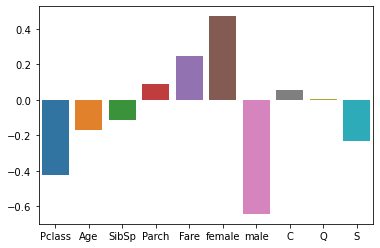

In [23]:
sns.barplot(x=X_df.columns, y=theta_hat[1:])
plt.show()

This plot shows that quite a few features got a non-zero weight, indicating they either contributed positively or negatively to the predicted survival chance of a passenger. The three most important predictive features seem to be the passenger class, the age of the passenger and whether the passenger was male or female. We cannot directly draw conclusions about the relationship between these features and whether or not a person survived based on this plot, but we *can* use it as a starting point for further analysis.

## Analyzing the data

First, let's take a look at a basic count plot to see how many people have survived overall.

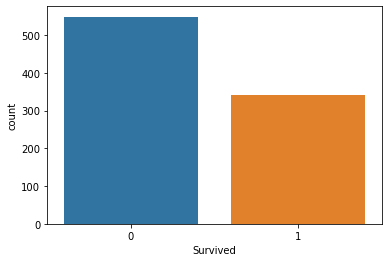

In [24]:
sns.countplot(x='Survived',data=data)
plt.show()

We can see from this plot that approximately 350 people have survived, while approximately 550 people have died overall.

Now, let's take a look at those 3 features specifically, and see how they affect the distribution.

### 1. Gender of the passenger

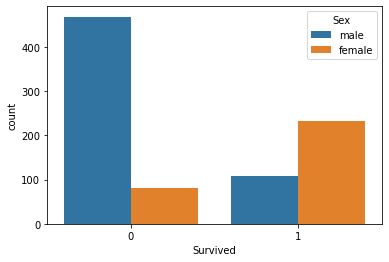

In [25]:
sns.countplot(x='Survived',hue='Sex',data=data)
plt.show()

### 2. Class of the passenger's cabin

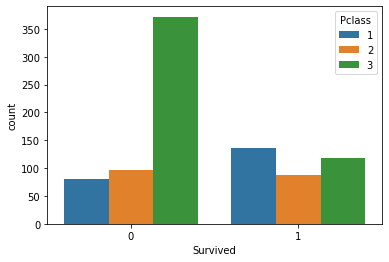

In [26]:
sns.countplot(x='Survived',hue='Pclass',data=data)
plt.show()

### 3. Age of the passenger

This is a continuous variable, so we can't plot all the distinct cases. Instead we'll use a barplot with the averages for both classes, and corresponding error bars.

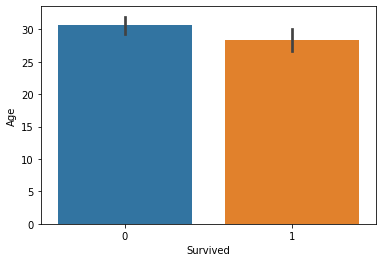

In [27]:
sns.barplot(x='Survived', y='Age', data=data)
plt.show()

## Creating hypotheses for the data

For each of the 3 features shown above, compare their individual impact on the survival chance of the passenger. For every feature, give your own hypothesis on why this feature is likely to have a positive or negative impact on the survivability of the passenger. Also, add how this then explains the positive or negative weight the feature seems to get in the learned logistic regression model:

**Q4. Gender of the passenger**

*It seems that women are relatively more likely to survive. I suspect that this may be the case because women are given priority during emergencies as "women and children" are/were allowed to board emergency boats and get life vests with priority. This explains the positive weight that the gender "woman" seems to get: it makes it more likely that teh person will survive. The opposite may be true for the males, which would explain the negative weight.*

**Q5. Class of the passenger's cabin**

*It seems that class 3 was much less likely to survive, class 1 was slightly more likely to survive and it seems that being in class 2 does not make much difference. The amount of people in class 3 that died is relatively high as a proportion of the total amount of people on the boat. This would explain the negative weight.*

**Q6. Age of the passenger**

*The data as such does not suggest that the age of the passenger makes much of a difference. Or at least, i'd say that age is not (on its own) a reliable indicator with just the bars above. This could have many causes. For example, particularly vulnerable individuals such as children and the elderly may have not survived and their influence on the mean could cancel each other out. So tye mean would not give an accurate picture of reality. Alternatively, age may not have been a relevant factor at all, but I doubt that since age can be linked to many other factors.  So i'd say that age may be linked to another factor like gender or class. For example, older people can be expected to have more money are more likely to fare in class 1 or 2. (e.g. older men were more likely to survive, but young men were less likely). And you could factor gender into this as well. This could explain the negative weight, as whatever the age is linked to such as class and/or gender such as male, would decrease the odds of survival.*
